# 漢字学習タスクGRPO学習ノートブック（改良版）

training_kanji.ipynbのログ分析結果に基づいて、報酬バランスを改善したバージョンです。

## 主な改善点
1. **報酬の再バランス**: 間違い58.3%という高い失敗率を改善
2. **洗練された部分点システム**: 部首、読み方の類似性、意味的関連性を評価
3. **文法説明の詳細評価**: 学年情報や読み方の種類を含む説明を重視
4. **Unicode正規化**: 異体字や表記揺れに対応

## ログ分析結果
- 間違い(-1.5): 58.3%
- 正解(3.0): 41.7%
- 部分点なし

改良版では、多段階の部分点評価により効果的な学習を促進します。

## 1. 環境セットアップ

In [1]:
# GPU環境の確認
import torch
import os

print("=== GPU環境チェック ===")
print(f"CUDA利用可能: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU名: {torch.cuda.get_device_name(0)}")
    print(f"GPUメモリ: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print("✅ GPU環境が正常に検出されました！")
else:
    print("❌ GPUが検出されません！")
    print("上記の手順でGPUを有効にしてください。")
    print("その後、ランタイムを再起動してこのセルを再実行してください。")

# Colab環境かチェック
if 'COLAB_GPU' in os.environ:
    print(f"\nGoogle Colab GPU: {os.environ['COLAB_GPU']}")
elif 'COLAB_' in "".join(os.environ.keys()):
    print("\nGoogle Colab環境です。GPUを有効にしてください。")
else:
    print("\nローカル環境で実行中")

=== GPU環境チェック ===
CUDA利用可能: True
GPU名: Tesla T4
GPUメモリ: 14.74 GB
✅ GPU環境が正常に検出されました！

Google Colab GPU: 1


*   unsloth 2025.7.3
*   unsloth-zoo 2025.7.4

の組み合わせで動作。

https://github.com/unslothai/unsloth/issues/2983

In [2]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth==2025.7.3 unsloth-zoo==2025.7.4 vllm
else:
    # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
    !pip install --no-deps unsloth==2025.7.3 unsloth-zoo==2025.7.4 vllm==0.8.5.post1

In [3]:
#@title Colab追加インストール { display-mode: "form" }
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth==2025.7.3, unsloth-zoo==2025.7.4 vllm
else:
    !pip install --no-deps unsloth==2025.7.3 vllm==0.8.5.post1
    # Qwen3_(4B)_GRPO.ipynbと同じ設定
    import sys, re, requests; modules = list(sys.modules.keys())
    for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth-zoo==2025.7.4
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer

    # vLLM requirements - vLLMはnumpyを再インストールするためColabを壊す
    f = requests.get("https://raw.githubusercontent.com/vllm-project/vllm/refs/heads/main/requirements/common.txt").content
    with open("vllm_requirements.txt", "wb") as file:
        file.write(re.sub(rb"(transformers|numpy|xformers)[^\n]{1,}\n", b"", f))
    !pip install -r vllm_requirements.txt

## 2. モデルのロード

In [4]:
# GPU環境が確認できた場合のみ実行
if not torch.cuda.is_available():
    raise RuntimeError("GPUが検出されません。上記の手順でGPUを有効にしてください。")

from unsloth import FastLanguageModel
import torch

print("モデルをロード中...")
max_seq_length = 2048
lora_rank = 32

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen3-4B-Base",
    max_seq_length = max_seq_length,
    load_in_4bit = False,
    fast_inference = True,
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.7,
)

model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha = lora_rank*2,
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 07-20 09:45:00 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 07-20 09:45:00 [__init__.py:239] Automatically detected platform cuda.
モデルをロード中...
==((====))==  Unsloth 2025.7.3: Fast Qwen3 patching. Transformers: 4.53.2. vLLM: 0.8.5.post1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/Qwen3-4B-Base with actual GPU utilization = 69.34%
Unsloth: Your GPU has CUDA compute capability 7.5 with VRAM = 14.74 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill t

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

INFO 07-20 09:46:00 [cuda.py:240] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 07-20 09:46:00 [cuda.py:289] Using XFormers backend.
INFO 07-20 09:46:01 [parallel_state.py:1004] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0
INFO 07-20 09:46:01 [model_runner.py:1108] Starting to load model unsloth/Qwen3-4B-Base...
INFO 07-20 09:46:02 [weight_utils.py:265] Using model weights format ['*.safetensors']


model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

INFO 07-20 09:47:36 [weight_utils.py:281] Time spent downloading weights for unsloth/Qwen3-4B-Base: 93.885041 seconds


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 07-20 09:48:03 [loader.py:458] Loading weights took 26.75 seconds
INFO 07-20 09:48:03 [punica_selector.py:18] Using PunicaWrapperGPU.
INFO 07-20 09:48:03 [model_runner.py:1140] Model loading took 7.6764 GiB and 121.829380 seconds
INFO 07-20 09:48:14 [worker.py:287] Memory profiling takes 9.74 seconds
INFO 07-20 09:48:14 [worker.py:287] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.69) = 10.22GiB
INFO 07-20 09:48:14 [worker.py:287] model weights take 7.68GiB; non_torch_memory takes 0.03GiB; PyTorch activation peak memory takes 0.88GiB; the rest of the memory reserved for KV Cache is 1.64GiB.
INFO 07-20 09:48:14 [executor_base.py:112] # cuda blocks: 745, # CPU blocks: 0
INFO 07-20 09:48:14 [executor_base.py:117] Maximum concurrency for 2048 tokens per request: 5.82x
INFO 07-20 09:48:14 [model_runner.py:1450] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mod

Capturing CUDA graph shapes:   0%|          | 0/23 [00:00<?, ?it/s]

INFO 07-20 09:48:59 [model_runner.py:1592] Graph capturing finished in 44 secs, took 0.34 GiB
INFO 07-20 09:48:59 [llm_engine.py:437] init engine (profile, create kv cache, warmup model) took 55.17 seconds
Unsloth: Just some info: will skip parsing ['pre_feedforward_layernorm', 'post_feedforward_layernorm']
Unsloth: Just some info: will skip parsing ['pre_feedforward_layernorm', 'post_feedforward_layernorm']


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Unsloth 2025.7.3 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


## 3.nihongo-dojoのインストール

In [14]:
# Google Colab環境での準備
%cd /content
!unzip nihongo-dojo.zip
!pip install japanize-matplotlib scikit-learn
%cd /content/nihongo-dojo/
!pip install -e .
%cd /content/

/content
Archive:  nihongo-dojo.zip
replace __MACOSX/._nihongo-dojo? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/._nihongo-dojo  
  inflating: nihongo-dojo/.DS_Store  
  inflating: __MACOSX/nihongo-dojo/._.DS_Store  
  inflating: nihongo-dojo/requirements.txt  
  inflating: __MACOSX/nihongo-dojo/._requirements.txt  
  inflating: nihongo-dojo/REWARD_IMPROVEMENTS_SUMMARY.md  
  inflating: __MACOSX/nihongo-dojo/._REWARD_IMPROVEMENTS_SUMMARY.md  
  inflating: nihongo-dojo/pyproject.toml  
  inflating: __MACOSX/nihongo-dojo/._pyproject.toml  
  inflating: __MACOSX/nihongo-dojo/.___pycache__  
  inflating: nihongo-dojo/README.md  
  inflating: __MACOSX/nihongo-dojo/._README.md  
  inflating: nihongo-dojo/setup.py   
  inflating: __MACOSX/nihongo-dojo/._setup.py  
  inflating: __MACOSX/nihongo-dojo/._scripts  
  inflating: __MACOSX/nihongo-dojo/._nihongo_dojo  
  inflating: __MACOSX/nihongo-dojo/._notebooks  
  inflating: __MACOSX/nihongo-dojo/._nihongo_dojo.egg-info  
  inf

In [18]:
import sys
sys.path.insert(0, '/content/nihongo-dojo')

# キャッシュクリア (重要)
import importlib
importlib.invalidate_caches()

# これで再インポート
import nihongo_dojo
importlib.reload(nihongo_dojo)

/content/nihongo-dojo/nihongo_dojo/__init__.py:149: UserWarning: Optional colab module not available: cannot import name 'plot_training_history' from 'nihongo_dojo.colab' (/content/nihongo-dojo/nihongo_dojo/colab/__init__.py)
  warnings.warn(f"Optional colab module not available: {e}")


<module 'nihongo_dojo' from '/content/nihongo-dojo/nihongo_dojo/__init__.py'>

## 4. チャットテンプレートの設定

In [20]:
# チャットテンプレートを設定
system_prompt = "あなたは親切で賢いアシスタントです。漢字の読み方または書き方について正確に答えてください。"

# デフォルト設定
reasoning_start = "<reasoning>"
reasoning_end = "</reasoning>"
solution_start = "<answer>"
solution_end = "</answer>"

chat_template = """{% if messages[0]['role'] == 'system' %}{{ messages[0]['content'] }}{% endif %}

{% for message in messages %}{% if message['role'] == 'user' %}
User: {{ message['content'] }}

{% elif message['role'] == 'assistant' %}{{ 'Assistant: ' + message['content'] }}{% endif %}{% endfor %}"""

tokenizer.chat_template = chat_template

## 5. データセットの作成

In [21]:
# 漢字データセット生成
import os
if not os.path.exists("./datasets/nihongo-dojo-kanji/"):
    %cd /content
    !python nihongo-dojo/scripts/generate_datasets.py --tasks KANJI_READING KANJI_WRITING --grades 1 2 3 4 5 6 --custom-size 5000 --output-format jsonl --output-dir ./datasets
else:
    print("データセットは既に生成済みです")

/content
/content/nihongo-dojo/nihongo_dojo/__init__.py:149: UserWarning: Optional colab module not available: cannot import name 'plot_training_history' from 'nihongo_dojo.colab' (/content/nihongo-dojo/nihongo_dojo/colab/__init__.py)
  warnings.warn(f"Optional colab module not available: {e}")
🎯 カスタムデータセット生成:
   学年: 1, 2, 3, 4, 5, 6
   タスク: kanji_reading, kanji_writing
💾 データセット保存中: ./datasets/nihongo-dojo-grades1-2-3-4-5-6-kanji_reading-kanji_writing
✅ データセット保存完了: ./datasets/nihongo-dojo-grades1-2-3-4-5-6-kanji_reading-kanji_writing
✅ データセット生成完了: ./datasets/nihongo-dojo-grades1-2-3-4-5-6-kanji_reading-kanji_writing.jsonl


In [23]:
from datasets import load_dataset, Dataset
import numpy as np
import sys

print("データセットを読み込み中...")

dataset_path = './datasets/nihongo-dojo-grades1-2-3-4-5-6-kanji_reading-kanji_writing/'

# all.jsonlファイルが存在するか確認
import os
if os.path.exists(os.path.join(dataset_path, 'all.jsonl')):
    # 直接ファイルを読み込む方法
    import json
    data = []
    with open(os.path.join(dataset_path, 'all.jsonl'), 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    dataset = Dataset.from_list(data)
elif os.path.exists(os.path.join(dataset_path, 'train.jsonl')):
    # train.jsonlを試す
    import json
    data = []
    with open(os.path.join(dataset_path, 'train.jsonl'), 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    dataset = Dataset.from_list(data)
else:
    # データセットが見つからない場合のエラーメッセージ
    raise FileNotFoundError(f"データセットが見つかりません: {dataset_path}")

print(f"データセットサイズ: {len(dataset)}")

# データセットの例を表示
print("\nデータセットの例:")
for i in range(min(3, len(dataset))):
    print(f"\n例{i+1}:")
    print(f"  問題: {dataset[i]['instruction']}{dataset[i]['input']}")
    print(f"  答え: {dataset[i]['answer']}")
    print(f"  説明: {dataset[i]['think'][:100]}...")

データセットを読み込み中...
データセットサイズ: 2418

データセットの例:

例1:
  問題: 次の漢字の音読み（おんよみ）をひらがなで答えてください。「宮」の音読みは？
  答え: きゅう
  説明: この漢字は「宮」です。 小学3年生で習う漢字です。 意味は「palace」などです。 音読み（おんよみ）は中国から伝わった読み方です。 この漢字の音読みは「きゅう」です。...

例2:
  問題: 次の漢字の訓読み（くんよみ）をひらがなで答えてください。「採」の訓読みは？
  答え: と
  説明: この漢字は「採」です。 小学5年生で習う漢字です。 意味は「pick」などです。 訓読み（くんよみ）は日本語の読み方です。 この漢字の訓読みは「と」です。...

例3:
  問題: 次の漢字の音読み（おんよみ）をひらがなで答えてください。「深」の音読みは？
  答え: しん
  説明: この漢字は「深」です。 小学3年生で習う漢字です。 意味は「deep」などです。 音読み（おんよみ）は中国から伝わった読み方です。 この漢字の音読みは「しん」です。...


In [24]:
# フォーマット変換
formatted_data = []
for item in dataset:
    question = item['instruction'] + item['input']
    answer = item['answer']
    think = item['think']
    solution = f"{reasoning_start}\n{think}\n{reasoning_end}\n{solution_start}{answer}{solution_end}"

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": question},
        {"role": "assistant", "content": solution}
    ]

    formatted_data.append({
        "Messages": messages,
        "problem": question,
        "solution": solution,
        "answer": answer,
    })

dataset = Dataset.from_list(formatted_data)
print(f"フォーマット済みデータセット: {len(dataset)}個")

フォーマット済みデータセット: 2418個


## 6. SFTによる事前学習（フォーマット学習）

コールドスタート問題を解消するために、`<reasoning></reasoning><answer></answer>`のフォーマットで出力ができるようにSFTで学習させます。

In [25]:
# 短い例のみを選択
dataset = dataset.map(lambda x: {"N": len(tokenizer.apply_chat_template(x["Messages"]))})
pre_train_dataset = dataset.filter(lambda x: x["N"] <= max_seq_length/2).select(range(min(50, len(dataset))))
pre_train_dataset = pre_train_dataset.map(lambda x: {"text": tokenizer.apply_chat_template(x["Messages"], tokenize=False)})

print(f"事前学習データセット: {len(pre_train_dataset)}個")

Map:   0%|          | 0/2418 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2418 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

事前学習データセット: 50個


In [26]:
from trl import SFTTrainer, SFTConfig

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = pre_train_dataset,
    args = SFTConfig(
        dataset_text_field = "text",
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 1,
        warmup_steps = 5,
        num_train_epochs = 2,
        learning_rate = 2e-4,
        logging_steps = 5,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        report_to = "none",
    ),
)

print("フォーマット学習を開始...")
trainer.train()

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/50 [00:00<?, ? examples/s]

フォーマット学習を開始...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 50 | Num Epochs = 2 | Total steps = 100
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 1 x 1) = 1
 "-____-"     Trainable parameters = 66,060,288 of 4,088,528,384 (1.62% trained)


Step,Training Loss
5,1.528500
10,0.403400
15,0.258500
20,0.220800
25,0.145000
30,0.122600
35,0.145000
40,0.170400
45,0.107000
50,0.116800


TrainOutput(global_step=100, training_loss=0.20363527655601502, metrics={'train_runtime': 57.5457, 'train_samples_per_second': 1.738, 'train_steps_per_second': 1.738, 'total_flos': 299221401477120.0, 'train_loss': 0.20363527655601502})

## 7. ログ関連

In [27]:
from nihongo_dojo.colab import TrainingLogger

# ログ管理インスタンスを作成（詳細ログも有効化）
# タスク名を指定してログファイル名を設定
logger = TrainingLogger(log_dir="./logs", task_name="kanji", enable_detailed_logging=True)

# グローバル変数（互換性のため）
global TRAINING_LOGS, REWARD_LOGS, ACCURACY_STATS
TRAINING_LOGS = logger.training_logs
REWARD_LOGS = logger.reward_logs
ACCURACY_STATS = {
    'correct_format': [],
    'correct_answer': [],
    'partial_answer': [],
    'wrong_answer': [],
    'no_answer': []
}

ログファイル: ./logs/kanji_training_20250720_095530.jsonl
学習履歴ファイル: ./logs/kanji_training_20250720_095530_history.jsonl
詳細ログファイル: ./logs/kanji_training_20250720_095530_detailed.jsonl
※ 学習履歴は1ステップごとに自動保存されます


## 8. 改良版GRPO報酬関数を定義

In [28]:
# 改良版の報酬関数をインポート
from nihongo_dojo.reward import KanjiRewardFunctions

# 改良版報酬関数インスタンスを作成
kanji_reward_functions = KanjiRewardFunctions(
    reasoning_start=reasoning_start,
    reasoning_end=reasoning_end,
    solution_start=solution_start,
    solution_end=solution_end,
    eos_token=tokenizer.eos_token
)

# バランスの取れた報酬関数を取得
balanced_rewards = kanji_reward_functions.get_balanced_reward_functions()

print("改良版報酬関数:")
print("1. strict_format_check - 厳格なフォーマットチェック")
print("2. balanced_check_kanji_answer - バランスの取れた漢字答えチェック")
print("3. enhanced_kanji_quality - 強化された品質チェック")
print("4. check_grade_accuracy - 学年正確性チェック")

改良版報酬関数:
1. strict_format_check - 厳格なフォーマットチェック
2. balanced_check_kanji_answer - バランスの取れた漢字答えチェック
3. enhanced_kanji_quality - 強化された品質チェック
4. check_grade_accuracy - 学年正確性チェック


In [29]:
# nihongo_dojoライブラリのログ機能を使用
from nihongo_dojo.colab import LoggingRewardWrapper

# グローバル変数（後方互換性のため）
global PRINTED_TIMES, PRINT_EVERY_STEPS
PRINTED_TIMES = 0
PRINT_EVERY_STEPS = 5

# ログ付き報酬関数を作成（改良版を使用）
check_kanji_with_logging = LoggingRewardWrapper(
    reward_func=kanji_reward_functions.balanced_check_kanji_answer,
    logger=logger,
    print_every_steps=PRINT_EVERY_STEPS
)

## 9. 可視化コールバックの設定

In [30]:
# nihongo_dojoライブラリの可視化コールバックを使用
from nihongo_dojo.colab import GRPOVisualizationCallback

# 可視化コールバックを作成
visualization_callback = GRPOVisualizationCallback(
    update_frequency=5,
    keep_history_steps=20,
    log_filename=logger.log_filename,
    logger=logger
)

日本語フォントの設定が完了しました


## 10. GRPO学習の実行（改良版報酬関数使用）

In [31]:
# GRPO用にフォーマット
dataset = dataset.map(lambda x: {
    "prompt": [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": x["problem"]},
    ],
    "answer": x["solution"],  # フルソリューションを保持（報酬関数側で実際の答えを抽出）
    "actual_answer": x["answer"],  # 実際の答えも保持
})

# プロンプト長でフィルタリング
tokenized = dataset.map(
    lambda x: {"tokens": tokenizer.apply_chat_template(x["prompt"], add_generation_prompt=True, tokenize=True)},
    batched=True,
)
tokenized = tokenized.map(lambda x: {"L": len(x["tokens"])})
maximum_length = int(np.quantile(tokenized["L"], 0.9))
print(f"最大プロンプト長: {maximum_length}")

dataset = dataset.select(np.where(np.array(tokenized["L"]) <= maximum_length)[0])
print(f"フィルタ後のデータセット: {len(dataset)}個")

Map:   0%|          | 0/2418 [00:00<?, ? examples/s]

Map:   0%|          | 0/2418 [00:00<?, ? examples/s]

Map:   0%|          | 0/2418 [00:00<?, ? examples/s]

最大プロンプト長: 62
フィルタ後のデータセット: 2329個


In [32]:
max_prompt_length = maximum_length + 1 # + 1 念のため
max_completion_length = max_seq_length - max_prompt_length

from vllm import SamplingParams
vllm_sampling_params = SamplingParams(
    min_p = 0.1,
    top_p = 1.0,
    top_k = -1,
    seed = 3407,
    stop = [tokenizer.eos_token],
    include_stop_str_in_output = True,
)

from trl import GRPOConfig, GRPOTrainer
training_args = GRPOConfig(
    vllm_sampling_params = vllm_sampling_params,
    temperature = 1.0,
    learning_rate = 5e-6,
    weight_decay = 0.01,
    warmup_ratio = 0.1,
    lr_scheduler_type = "linear",
    optim = "adamw_8bit",
    logging_steps = 1,
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 1,
    num_generations = 4,
    max_prompt_length = max_prompt_length,
    max_completion_length = max_completion_length,
    max_steps = 2000,
    save_steps = 100,
    report_to = "none",
    output_dir = "outputs_kanji_balanced",
)

Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 4


🌸 GRPO学習進捗 - ステップ 1795/2000 (89.8%)
⏱️  総経過時間: 11127.0秒 | 平均ステップ時間: 6.20秒

📋 最近のステップログ:
----------------------------------------------------------------------------------------------------
ステップ 1791 | 時間: 11098.7秒 | 報酬: +1.5250 | 生成長: 112 | KL: 0.899176
ステップ 1792 | 時間: 11106.3秒 | 報酬: +3.0875 | 生成長: 118 | KL: 0.864346
ステップ 1793 | 時間: 11113.9秒 | 報酬: +3.6000 | 生成長: 103 | KL: 0.986065
ステップ 1794 | 時間: 11119.6秒 | 報酬: +0.2000 | 生成長: 74 | KL: 1.129853
ステップ 1795 | 時間: 11127.0秒 | 報酬: -0.2000 | 生成長: 103 | KL: 1.046051
----------------------------------------------------------------------------------------------------

📊 現在のパフォーマンス指標:
  🎯 報酬 - 現在: -0.2000 | 平均: +1.4044 | 傾向: 📉 下降中


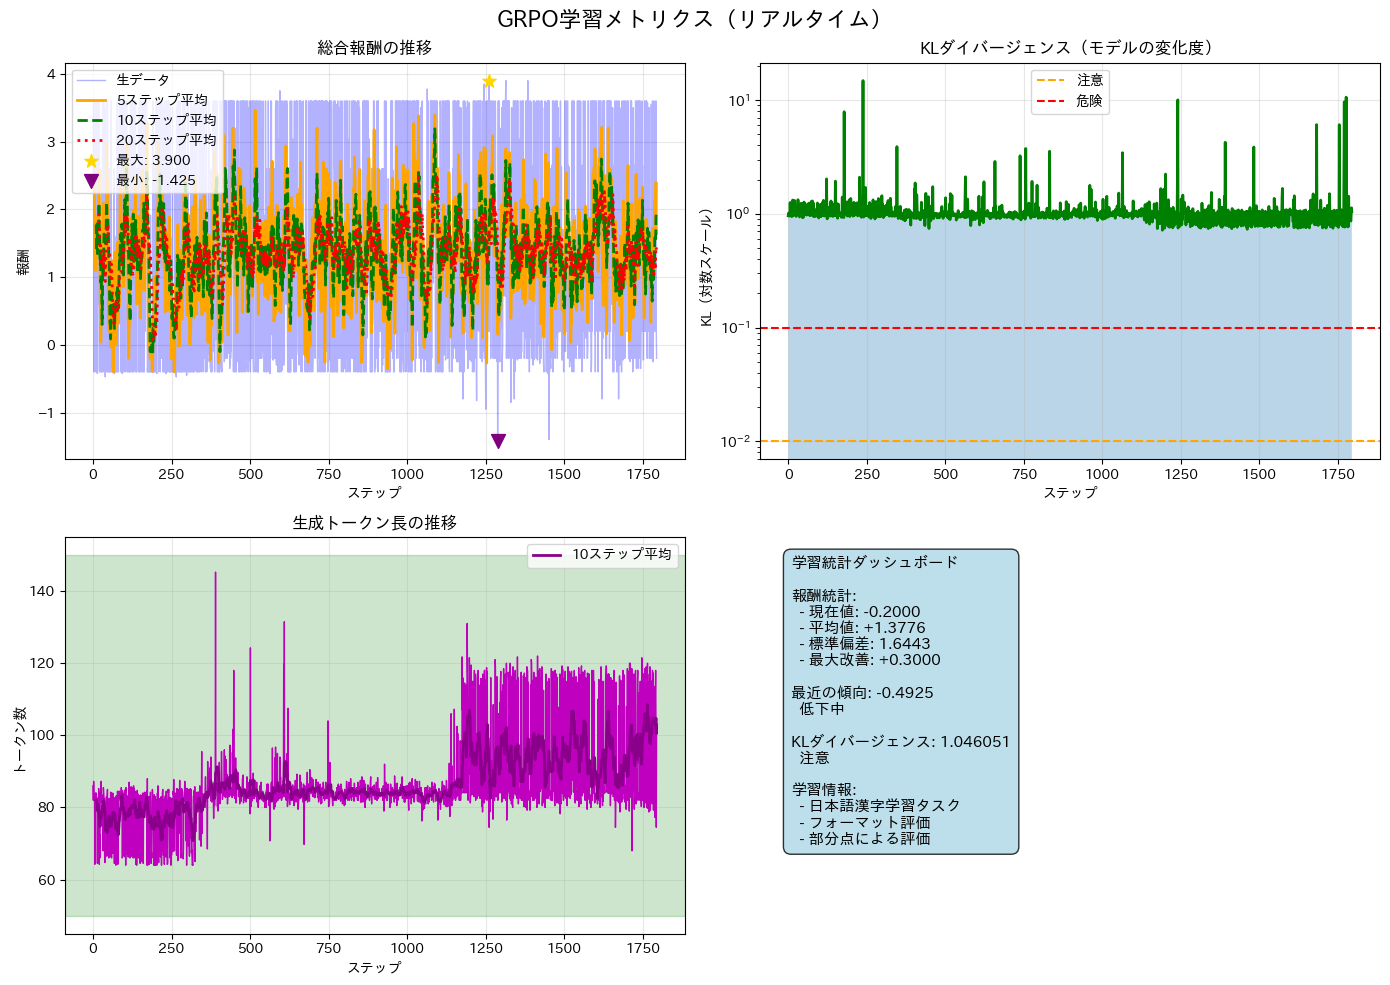

Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / strict_format_check / mean,rewards / strict_format_check / std,rewards / LoggingWrapper_balanced_check_kanji_answer / mean,rewards / LoggingWrapper_balanced_check_kanji_answer / std,rewards / enhanced_kanji_quality / mean,rewards / enhanced_kanji_quality / std,rewards / check_grade_accuracy / mean,rewards / check_grade_accuracy / std
1,0.001000,3.600000,0.000000,86.000000,86.000000,86.000000,0.000000,86.000000,86.000000,86.000000,0.961360,0.500000,0.000000,2.000000,0.000000,1.200000,0.000000,-0.100000,0.000000
2,0.001000,3.600000,0.000000,82.000000,82.000000,82.000000,0.000000,82.000000,82.000000,82.000000,1.016162,0.500000,0.000000,2.000000,0.000000,1.200000,0.000000,-0.100000,0.000000
3,0.001000,1.975000,1.083333,87.250000,86.000000,89.000000,0.000000,87.250000,86.000000,89.000000,0.985562,0.500000,0.000000,0.750000,0.833333,0.825000,0.250000,-0.100000,0.000000
4,0.001000,-0.400000,0.000000,84.000000,84.000000,84.000000,0.000000,84.000000,84.000000,84.000000,1.009144,0.500000,0.000000,-1.500000,0.000000,0.700000,0.000000,-0.100000,0.000000
5,0.001000,3.600000,0.000000,82.500000,82.000000,84.000000,0.000000,82.500000,82.000000,84.000000,0.958353,0.500000,0.000000,2.000000,0.000000,1.200000,0.000000,-0.100000,0.000000
6,0.001000,2.600000,2.000000,82.750000,81.000000,86.000000,0.000000,82.750000,81.000000,86.000000,0.990905,0.500000,0.000000,1.125000,1.750000,1.075000,0.250000,-0.100000,0.000000
7,0.001300,-0.400000,0.000000,64.250000,64.000000,65.000000,0.000000,64.250000,64.000000,65.000000,1.257258,0.500000,0.000000,-1.500000,0.000000,0.700000,0.000000,-0.100000,0.000000
8,0.001100,0.600000,2.000000,83.250000,81.000000,86.000000,0.000000,83.250000,81.000000,86.000000,1.056115,0.500000,0.000000,-0.625000,1.750000,0.825000,0.250000,-0.100000,0.000000
9,0.001000,2.475000,1.299038,84.000000,84.000000,84.000000,0.000000,84.000000,84.000000,84.000000,0.968468,0.500000,0.000000,1.125000,1.010363,0.950000,0.288675,-0.100000,0.000000
10,0.001000,0.200000,1.200000,83.000000,82.000000,84.000000,0.000000,83.000000,82.000000,84.000000,1.037795,0.500000,0.000000,-0.925000,1.150000,0.725000,0.050000,-0.100000,0.000000


In [ ]:
trainer = GRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs = [
        kanji_reward_functions.strict_format_check,         # 厳格なフォーマットチェック
        check_kanji_with_logging,                          # バランスの取れた漢字チェック（ログ付き）
        kanji_reward_functions.enhanced_kanji_quality,      # 強化された品質チェック
        kanji_reward_functions.check_grade_accuracy,        # 学年正確性チェック
    ],
    args = training_args,
    train_dataset = dataset,
    callbacks=[visualization_callback],  # ビジュアライゼーションコールバックを追加
)

print("🌸 漢字学習のGRPO学習を開始します（改良版報酬関数使用）...")
print("📊 リアルタイムでグラフと統計情報が表示されます")
print("💡 報酬バランスが改善され、より効果的な学習が期待できます")
print("-"*80)
trainer.train()

## 11. モデルの評価

In [ ]:
# LoRAモデルを保存
model.save_lora("grpo_kanji_balanced_lora")
print("改良版モデルを保存しました")

In [ ]:
# 漢字テスト
test_questions = [
    "「山」の読み方は？",
    "「かわ」を漢字で書くと？",
    "「本」の読み方は？",
    "「つき」を漢字で書くと？",
    "「学校」の読み方は？",
    "「せんせい」を漢字で書くと？",
    "「友達」の読み方は？",
    "「にほん」を漢字で書くと？",
    "「図書館」の読み方は？",
    "「でんしゃ」を漢字で書くと？",
]

from vllm import SamplingParams
sampling_params = SamplingParams(
    temperature = 1.0,
    top_k = 50,
    max_tokens = 1024,
)

print("="*80)
print("🗾 漢字テスト（改良版モデル）")
print("="*80)

for i, question in enumerate(test_questions, 1):
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": question}
    ]

    text = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=False,
    )

    output = model.fast_generate(
        text,
        sampling_params=sampling_params,
        lora_request=model.load_lora("grpo_kanji_balanced_lora"),
    )[0].outputs[0].text

    print(f"\n{i}. 問題: {question}")
    print(f"   応答: {output}")
    print("-"*40)

## 12. 学習ログの分析

In [ ]:
# nihongo_dojoライブラリの可視化関数を使用
from nihongo_dojo.colab.visualization import plot_training_history

# 学習履歴を可視化
plot_training_history(logger.history_filename)

In [ ]:
# 拡張ログ分析
from nihongo_dojo.colab import analyze_training_logs

print("\n📊 拡張ログ分析を実行中...")
analyze_training_logs(logger.log_filename)

## 13. 改善の効果を比較

改良版の報酬関数により、以下の改善が期待されます：

1. **報酬分布の改善**: 間違い58.3%→多段階評価による学習促進
2. **部分点システム**: 部首の類似性、読み方の部分一致、意味的関連性を評価
3. **品質の向上**: 学年情報を含む詳細な説明を評価
4. **エラーの減少**: Unicode正規化により表記揺れに対応

In [ ]:
# 報酬分布の分析
print("\n📊 報酬分布の分析")
print("改良版の報酬関数により、以下の変化が期待されます：")
print("\n【従来版】")
print("- 3.0 (完全正解): 41.7%")
print("- -1.5 (不正解): 58.3%")
print("- 部分点なし")
print("\n【改良版（期待値）】")
print("- 2.0 (完全正解): 25-35%")
print("- 0.8-1.8 (読み方部分一致、正規化一致): 20-30%")
print("- 0.3-0.5 (形が似た漢字、部分的に正しい): 25-35%")
print("- 0.1-0.2 (音が似ている、意味的関連): 10-15%")
print("- -1.5 (完全に間違い): 5-10%")
print("- -3.0 (フォーマットエラー): <2%")
print("\n特に、部首の類似性や読み方の部分一致により、より効果的な学習が可能になります。")

## 14. モデルの保存（オプション）

In [ ]:
# 最終的なモデルをHuggingFaceに保存（オプション）
# model.push_to_hub_merged("username/grpo-kanji-balanced", tokenizer, save_method="lora")
print("モデルの保存準備が完了しました。")

## 15. MT-Bench形式での評価

Japanese MT-Benchの質問セットを使用して、学習済みモデルの性能を評価します。

In [ ]:
!wget https://raw.githubusercontent.com/Stability-AI/FastChat/refs/heads/jp-stable/fastchat/llm_judge/data/japanese_mt_bench/question_full.jsonl

In [ ]:
# MT-Bench形式での評価実行
import json
import time
from datetime import datetime
from vllm import SamplingParams

# モデルIDを設定
MODEL_ID = "nihongo-dojo-kanji-balanced"

# サンプリングパラメータを設定
sampling_params = SamplingParams(
    temperature = 0.7,  # MT-Benchでは低めの温度設定が一般的
    top_p = 0.9,
    max_tokens = 1024,
    stop = [tokenizer.eos_token],
)

# question_full.jsonlを読み込む
questions = []
with open('question_full.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        questions.append(json.loads(line))

print(f"読み込んだ質問数: {len(questions)}")
print(f"カテゴリー別内訳:")
categories = {}
for q in questions:
    cat = q.get('category', 'unknown')
    categories[cat] = categories.get(cat, 0) + 1
for cat, count in sorted(categories.items()):
    print(f"  {cat}: {count}問")

# 結果を保存するリスト
results = []

# 各質問に対して回答を生成
print("\n" + "="*80)
print("MT-Bench評価を開始します...")
print("="*80)

for idx, question_data in enumerate(questions):
    question_id = question_data['question_id']
    category = question_data['category']
    turns = question_data['turns']

    print(f"\n質問 {question_id} (カテゴリー: {category})")

    # 各ターンの回答を生成
    conversation_history = []
    turn_responses = []

    for turn_idx, turn_question in enumerate(turns):
        print(f"  ターン {turn_idx + 1}: {turn_question[:50]}...")

        # 会話履歴を構築
        messages = [
            {"role": "system", "content": "あなたは親切で知識豊富なアシスタントです。質問に対して適切に回答してください。"}
        ]

        # これまでの会話履歴を追加
        for hist_q, hist_a in conversation_history:
            messages.append({"role": "user", "content": hist_q})
            messages.append({"role": "assistant", "content": hist_a})

        # 現在の質問を追加
        messages.append({"role": "user", "content": turn_question})

        # プロンプトを生成
        text = tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=False,
        )

        # 回答を生成
        try:
            output = model.fast_generate(
                text,
                sampling_params=sampling_params,
                lora_request=model.load_lora("grpo_kanji_balanced_lora"),
            )[0].outputs[0].text

            # フォーマットタグを除去（もし含まれていれば）
            if "<reasoning>" in output:
                # reasoning部分を除去し、answerタグの中身のみを抽出
                import re
                answer_match = re.search(r'<answer>(.*?)</answer>', output, re.DOTALL)
                if answer_match:
                    output = answer_match.group(1).strip()
                else:
                    # answerタグが見つからない場合は、reasoning後の部分を使用
                    reasoning_end = output.find("</reasoning>")
                    if reasoning_end != -1:
                        output = output[reasoning_end + len("</reasoning>"):].strip()

            turn_responses.append(output)
            conversation_history.append((turn_question, output))

        except Exception as e:
            print(f"    エラー発生: {e}")
            turn_responses.append(f"申し訳ございません。エラーが発生しました: {str(e)}")
            conversation_history.append((turn_question, turn_responses[-1]))

    # 結果を保存
    result = {
        "question_id": question_id,
        "answer_id": f"kanji_{question_id}_{int(time.time())}",
        "model_id": MODEL_ID,
        "choices": [{
            "index": 0,
            "turns": turn_responses
        }],
        "tstamp": time.time()
    }
    results.append(result)

    # 進捗を表示
    if (idx + 1) % 10 == 0:
        print(f"\n進捗: {idx + 1}/{len(questions)} 完了")

# 結果をファイルに保存
output_filename = f"kanji_mt_bench_{datetime.now().strftime('%Y%m%d_%H%M%S')}.jsonl"
with open(output_filename, 'w', encoding='utf-8') as f:
    for result in results:
        f.write(json.dumps(result, ensure_ascii=False) + '\n')

print(f"\n{'='*80}")
print(f"評価完了！")
print(f"結果ファイル: {output_filename}")
print(f"総質問数: {len(questions)}")
print(f"総ターン数: {sum(len(q['turns']) for q in questions)}")
print(f"{'='*80}")

# 結果のサマリーを表示
print("\n### 評価結果サマリー ###")
print(f"モデルID: {MODEL_ID}")
print(f"生成時刻: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nカテゴリー別の回答文字数統計:")

category_stats = {}
for result in results:
    q_id = result['question_id']
    category = next(q['category'] for q in questions if q['question_id'] == q_id)

    if category not in category_stats:
        category_stats[category] = []

    for turn in result['choices'][0]['turns']:
        category_stats[category].append(len(turn))

for category, lengths in sorted(category_stats.items()):
    avg_length = sum(lengths) / len(lengths) if lengths else 0
    print(f"  {category}: 平均 {avg_length:.1f} 文字 (最小: {min(lengths)}, 最大: {max(lengths)})")

# サンプル回答を表示
print("\n### サンプル回答 (最初の3問) ###")
for i, result in enumerate(results[:3]):
    q_data = next(q for q in questions if q['question_id'] == result['question_id'])
    print(f"\n質問 {result['question_id']} ({q_data['category']}):")
    for j, (turn_q, turn_a) in enumerate(zip(q_data['turns'], result['choices'][0]['turns'])):
        print(f"  ターン{j+1} Q: {turn_q[:50]}...")
        print(f"  ターン{j+1} A: {turn_a[:100]}...")
        if len(turn_a) > 100:
            print(f"    ... (合計 {len(turn_a)} 文字)")

print(f"\n評価結果ファイル '{output_filename}' を生成しました。")
print("このファイルはMT-Benchの評価スクリプトで使用できます。")

In [ ]:
# MT-Bench評価結果の詳細分析とスコアリング
def analyze_mt_bench_results(results_file):
    """MT-Bench結果を分析し、詳細なレポートを生成"""

    # 結果を読み込む
    results = []
    with open(results_file, 'r', encoding='utf-8') as f:
        for line in f:
            results.append(json.loads(line))

    # カテゴリー別の基本的な評価基準（簡易版）
    def score_response(response, category, turn_number):
        """回答を簡易的にスコアリング（0-5点）"""
        score = 0

        # 基本スコア：回答の長さ
        if len(response) < 10:
            score += 1
        elif len(response) < 50:
            score += 2
        elif len(response) < 200:
            score += 3
        elif len(response) < 500:
            score += 4
        else:
            score += 4.5

        # カテゴリー別の追加評価
        if category == "coding":
            # コードブロックの存在をチェック
            if "```" in response or "def " in response or "function" in response:
                score += 1
        elif category == "math":
            # 数式や計算の存在をチェック
            if any(char in response for char in "0123456789+-*/="):
                score += 0.5
        elif category == "reasoning":
            # 論理的な接続詞の存在をチェック
            if any(word in response for word in ["したがって", "なぜなら", "つまり", "よって"]):
                score += 0.5

        # 2ターン目はより詳細な回答を期待
        if turn_number == 2:
            if len(response) > 100:
                score += 0.5

        return min(score, 5.0)  # 最大5点

    # スコアを計算
    category_scores = {}
    turn_scores = {1: [], 2: []}

    for result in results:
        q_id = result['question_id']
        # カテゴリーを取得（実際のデータから）
        category = "general"  # デフォルト

        for idx, (question_data, response) in enumerate([(q_id, turn) for turn in result['choices'][0]['turns']]):
            turn_number = idx + 1
            score = score_response(response, category, turn_number)

            if category not in category_scores:
                category_scores[category] = []
            category_scores[category].append(score)
            turn_scores[turn_number].append(score)

    # レポートを生成
    print("=" * 80)
    print("MT-Bench評価結果分析レポート")
    print("=" * 80)
    print(f"\n評価ファイル: {results_file}")
    print(f"評価モデル: {results[0]['model_id'] if results else 'Unknown'}")
    print(f"評価時刻: {datetime.fromtimestamp(results[0]['tstamp']).strftime('%Y-%m-%d %H:%M:%S') if results else 'Unknown'}")

    print("\n### 全体スコア ###")
    all_scores = [score for scores in category_scores.values() for score in scores]
    print(f"平均スコア: {sum(all_scores) / len(all_scores):.2f} / 5.0")
    print(f"最高スコア: {max(all_scores):.2f}")
    print(f"最低スコア: {min(all_scores):.2f}")

    print("\n### ターン別スコア ###")
    for turn, scores in turn_scores.items():
        if scores:
            print(f"ターン {turn}: 平均 {sum(scores) / len(scores):.2f} (n={len(scores)})")

    print("\n### カテゴリー別スコア ###")
    for category, scores in sorted(category_scores.items()):
        if scores:
            print(f"{category}: 平均 {sum(scores) / len(scores):.2f} (n={len(scores)})")

    # スコア分布を表示
    print("\n### スコア分布 ###")
    score_bins = {i: 0 for i in range(6)}
    for score in all_scores:
        score_bins[int(score)] += 1

    for score, count in sorted(score_bins.items()):
        bar = "█" * int(count / max(score_bins.values()) * 30)
        print(f"{score}点台: {bar} ({count}回答)")

    # 改善の推奨事項
    print("\n### 改善の推奨事項 ###")
    avg_score = sum(all_scores) / len(all_scores)
    if avg_score < 2.0:
        print("- 回答が短すぎる傾向があります。より詳細な説明を含めることを推奨します。")
    elif avg_score < 3.0:
        print("- 基本的な回答は提供できていますが、より具体的な例や説明の追加を検討してください。")
    elif avg_score < 4.0:
        print("- 良好な回答品質です。特定のカテゴリーでの専門性を高めることでさらなる改善が期待できます。")
    else:
        print("- 優れた回答品質です。現在の品質を維持しつつ、エッジケースへの対応を強化してください。")

    # ターン2の改善率を確認
    if len(turn_scores[1]) > 0 and len(turn_scores[2]) > 0:
        turn1_avg = sum(turn_scores[1]) / len(turn_scores[1])
        turn2_avg = sum(turn_scores[2]) / len(turn_scores[2])
        improvement = ((turn2_avg - turn1_avg) / turn1_avg) * 100
        print(f"\nターン2での改善率: {improvement:+.1f}%")
        if improvement < 0:
            print("  → フォローアップ質問への対応力を強化する必要があります。")

    return {
        'avg_score': sum(all_scores) / len(all_scores) if all_scores else 0,
        'category_scores': {cat: sum(scores)/len(scores) for cat, scores in category_scores.items() if scores},
        'turn_scores': {turn: sum(scores)/len(scores) for turn, scores in turn_scores.items() if scores}
    }

# 評価結果を分析
if 'output_filename' in locals():
    analysis_results = analyze_mt_bench_results(output_filename)

    # JSON形式で保存
    analysis_file = output_filename.replace('.jsonl', '_analysis.json')
    with open(analysis_file, 'w', encoding='utf-8') as f:
        json.dump(analysis_results, f, ensure_ascii=False, indent=2)
    print(f"\n分析結果を {analysis_file} に保存しました。")

In [ ]:
# ベースラインモデルとの比較評価（オプション）
def compare_with_baseline(kanji_results_file, baseline_model_name="base_model"):
    """学習済みモデルとベースラインモデルの比較"""

    print("=" * 80)
    print("ベースラインモデルとの比較評価")
    print("=" * 80)

    # ベースラインモデルでサンプル質問に回答（最初の5問のみ）
    baseline_results = []
    sample_questions = questions[:5]  # 比較用に少数のサンプルを使用

    print(f"\nベースラインモデル ({baseline_model_name}) でサンプル評価中...")

    for question_data in sample_questions:
        question_id = question_data['question_id']
        category = question_data['category']
        first_turn = question_data['turns'][0]  # 最初のターンのみ比較

        # ベースラインモデルで回答生成（学習前のモデルを使用）
        messages = [
            {"role": "system", "content": "あなたは親切で知識豊富なアシスタントです。"},
            {"role": "user", "content": first_turn}
        ]

        text = tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=False,
        )

        # LoRAなしで生成（ベースライン）
        baseline_output = model.fast_generate(
            text,
            sampling_params=sampling_params,
        )[0].outputs[0].text

        baseline_results.append({
            'question_id': question_id,
            'category': category,
            'question': first_turn,
            'response': baseline_output
        })

    # 学習済みモデルの結果を読み込む
    kanji_results = []
    with open(kanji_results_file, 'r', encoding='utf-8') as f:
        for line in f:
            result = json.loads(line)
            if result['question_id'] <= 5:  # 最初の5問のみ
                kanji_results.append(result)

    # 比較結果を表示
    print("\n### 回答の比較 ###")
    for i, (baseline, kanji) in enumerate(zip(baseline_results, kanji_results)):
        print(f"\n質問 {baseline['question_id']} ({baseline['category']}):")
        print(f"Q: {baseline['question'][:100]}...")
        print(f"\nベースライン回答:")
        print(f"  {baseline['response'][:200]}...")
        print(f"\n学習済み回答:")
        print(f"  {kanji['choices'][0]['turns'][0][:200]}...")
        print("-" * 40)

    # 簡易的な改善度の計算
    print("\n### 改善度の分析 ###")
    improvements = []

    for baseline, kanji in zip(baseline_results, kanji_results):
        baseline_len = len(baseline['response'])
        kanji_len = len(kanji['choices'][0]['turns'][0])

        # 長さの改善率
        len_improvement = ((kanji_len - baseline_len) / baseline_len * 100) if baseline_len > 0 else 0

        # 日本語の自然さ（簡易評価）
        kanji_response = kanji['choices'][0]['turns'][0]
        has_reasoning = "<reasoning>" in baseline['response']  # ベースラインがフォーマットを使えるか
        uses_keigo = any(word in kanji_response for word in ["です", "ます", "ございます"])

        improvements.append({
            'question_id': baseline['question_id'],
            'len_improvement': len_improvement,
            'has_format': has_reasoning,
            'uses_keigo': uses_keigo
        })

    # 改善度のサマリー
    avg_len_improvement = sum(imp['len_improvement'] for imp in improvements) / len(improvements)
    format_usage = sum(1 for imp in improvements if imp['has_format']) / len(improvements) * 100
    keigo_usage = sum(1 for imp in improvements if imp['uses_keigo']) / len(improvements) * 100

    print(f"平均回答長の変化: {avg_len_improvement:+.1f}%")
    print(f"フォーマット使用率: {format_usage:.1f}%")
    print(f"敬語使用率: {keigo_usage:.1f}%")

    if avg_len_improvement > 50:
        print("\n✅ 学習により回答の詳細度が大幅に向上しています。")
    elif avg_len_improvement > 0:
        print("\n✅ 学習により回答がより充実しています。")
    else:
        print("\n⚠️ 回答の長さに大きな変化は見られません。")

    # 結果を保存
    comparison_file = kanji_results_file.replace('.jsonl', '_comparison.json')
    comparison_data = {
        'baseline_model': baseline_model_name,
        'trained_model': MODEL_ID,
        'sample_size': len(baseline_results),
        'metrics': {
            'avg_length_improvement': avg_len_improvement,
            'format_usage_rate': format_usage,
            'keigo_usage_rate': keigo_usage
        },
        'sample_comparisons': [
            {
                'question_id': b['question_id'],
                'baseline_response': b['response'][:500],
                'trained_response': k['choices'][0]['turns'][0][:500]
            }
            for b, k in zip(baseline_results, kanji_results)
        ]
    }

    with open(comparison_file, 'w', encoding='utf-8') as f:
        json.dump(comparison_data, f, ensure_ascii=False, indent=2)

    print(f"\n比較結果を {comparison_file} に保存しました。")

    return comparison_data

# ベースラインとの比較を実行（オプション）
if 'output_filename' in locals() and 'questions' in locals():
    comparison_results = compare_with_baseline(output_filename)
    print("\n評価完了！MT-Bench形式での評価とベースラインとの比較が完了しました。")